# Mathematical Underpinnings - Lab 10

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import scale

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import Lasso

## Task 1

In [4]:
df = pd.read_csv('prostate.data', sep="\t", index_col=0)

In [5]:
X = np.array(df.iloc[:, 0:8])
Y = np.array(df.iloc[:, 8])

In [6]:
X = scale(X)
Y = scale(Y)

### a)

In [7]:
# fit
mod_lars = Lars(fit_intercept=False)
mod_lars.fit(X, Y)

Lars(fit_intercept=False)

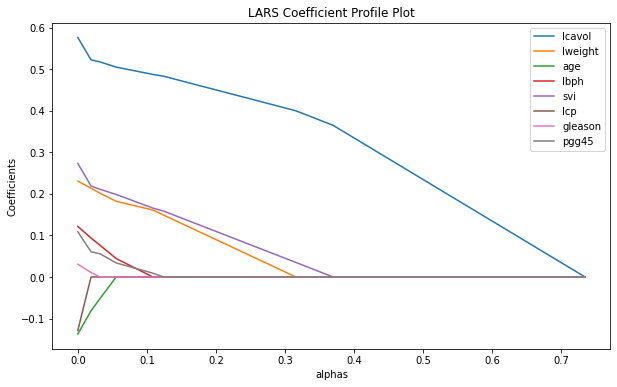

In [8]:
# plot
plt.figure(figsize=(10, 6))
for i in range(X.shape[1]):
    plt.plot(mod_lars.alphas_, mod_lars.coef_path_[i], label=df.columns[i])
plt.xlabel('alphas')
plt.ylabel('Coefficients')
plt.title('LARS Coefficient Profile Plot')
plt.legend()
plt.show()

Order in which the variables are included in the model:

In [9]:
order_of_inclusion = np.argmax(mod_lars.coef_path_ != 0, axis=1)
order_of_inclusion = np.argsort(order_of_inclusion)
variables_included_order = df.columns[order_of_inclusion]
print("Order in which the variables are included in the model:")
print(variables_included_order)

Order in which the variables are included in the model:
Index(['lcavol', 'svi', 'lweight', 'pgg45', 'lbph', 'age', 'gleason', 'lcp'], dtype='object')


### b)

In [10]:
mod_lars.alphas_[0]

0.7344603262136731

### b1)

In [11]:
# Find the biggest correlation between Y and column in X
correlations = np.dot(X.T, Y)
argmax_correlation_index = np.argmax(np.abs(correlations))
argmax_correlation_name = df.columns[argmax_correlation_index]
max_correlation = np.max(np.abs(correlations))

print(f"The biggest correlation with Y is with \"{argmax_correlation_name}\": {max_correlation}")

The biggest correlation with Y is with "lcavol": 71.24265164272629


### b2)

In [12]:
# Select the first variable
X1 = X[:, argmax_correlation_index].reshape(-1, 1)
model_ols = LinearRegression(fit_intercept=False)
model_ols.fit(X1, Y)
alpha_1 = model_ols.coef_

print(f"Alpha for the first variable \"{argmax_correlation_name}\": {alpha_1}")

Alpha for the first variable "lcavol": [0.73446033]


### b3)

In [13]:
# Residuals for different alpha values
correlations_residuals = np.zeros((101,8))
alpha_values = np.linspace(0, 1, 101)
for i, alpha in enumerate(alpha_values):
    residual = Y - alpha * model_ols.predict(X1)
    # Compute correlations
    correlations_residuals[i,:] = np.corrcoef(X.T, residual.T)[-1,:8]

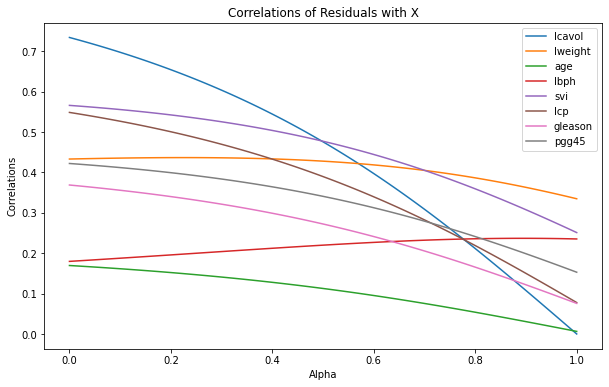

In [14]:
# Plot the correlations
plt.figure(figsize=(10, 6))
for i in range(X.shape[1]):
    plt.plot(alpha_values, correlations_residuals[:, i], label=df.columns[i])
plt.xlabel('Alpha')
plt.ylabel('Correlations')
plt.title('Correlations of Residuals with X')
plt.legend()
plt.show()

### b4)

In [15]:
second_index = np.nan  # Initialize second index as NaN
approx_alpha = np.nan  # Initialize approximate alpha as NaN

# Iterate over alpha values to find the first intersection
for i, alpha in enumerate(alpha_values):
    if np.any(correlations_residuals[i, argmax_correlation_index] < correlations_residuals[i, :]):
        # Find the index of the second variable at the intersection
        second_index = np.where(correlations_residuals[i, argmax_correlation_index] < correlations_residuals[i, :])[0][0]
        approx_alpha = alpha  # Store the approximate alpha value
        break

# Get the name of the second variable
second_name = df.columns[second_index]

# Print the name of the second variable
print(f"The second variable selected by LARS is \"{second_name}\" for approximate α ̃2: {np.round(approx_alpha,2)}")

# Check if Cor(r1,α ̃2 , XS1 ) = Cor(r1,α ̃2 , Xi)
print(f"Correlation with X1 at alpha={alpha_values[i]}: {correlations_residuals[i, argmax_correlation_index]}")
print(f"Correlation with Xs1 at alpha={alpha_values[i]}: {correlations_residuals[i, second_index]}")
print(f"Correlation with X1 at alpha={alpha_values[i-1]}: {correlations_residuals[i-1, argmax_correlation_index]}")
print(f"Correlation with Xs1 at alpha={alpha_values[i-1]}: {correlations_residuals[i-1, second_index]}")
if correlations_residuals[i, argmax_correlation_index] < correlations_residuals[i, second_index] and correlations_residuals[i-1, argmax_correlation_index] > correlations_residuals[i-1, second_index]:
    print(f"Correlations with X1 and Xs1 are equal at point somewhere beetween: {alpha_values[i-1]} and {alpha_values[i]}")
    

The second variable selected by LARS is "svi" for approximate α ̃2: 0.5
Correlation with X1 at alpha=0.5: 0.4759095723474519
Correlation with Xs1 at alpha=0.5: 0.4773453757968736
Correlation with X1 at alpha=0.49: 0.48322201078631816
Correlation with Xs1 at alpha=0.49: 0.48028187346150203
Correlations with X1 and Xs1 are equal at point somewhere beetween: 0.49 and 0.5


### b5)

$$ \textrm{Cor}(Y - \tilde\alpha\hat Y, X_i) = ... \cdot\textrm{Cor}(Y, X_i) - ... \cdot \tilde\alpha \cdot \textrm{Cor}(\tilde\alpha\hat Y, X_i) $$

In our case, $i=0$, $j=4$:
$$ |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_i)| = |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_j)|$$

In [16]:
# Residuals for different alpha values
formula_results = np.zeros((101,8))
alpha_values = np.linspace(0, 1, 101)
Y_p = model_ols.predict(X1)
for i, alpha in enumerate(alpha_values):
    var_cor = np.sqrt(np.var(Y)) * np.corrcoef(X.T, Y.T)[-1,:8]
    var_cor_p = np.sqrt(np.var(Y_p)) * alpha * np.corrcoef(X.T, Y_p.T)[-1,:8]
    formula_results[i,:] = var_cor - var_cor_p

(101, 8)


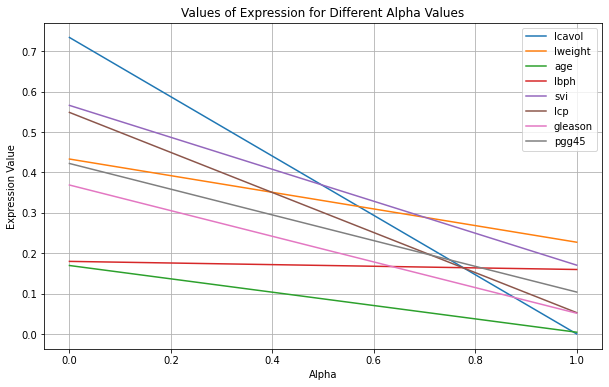

In [17]:
# Plot the results for each variable
print(formula_results.shape)
plt.figure(figsize=(10, 6))
for i in range(X.shape[1]):
    plt.plot(alpha_values, formula_results[:,i], label=df.columns[i])
plt.xlabel('Alpha')
plt.ylabel('Expression Value')
plt.title('Values of Expression for Different Alpha Values')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
out = np.ones(X.shape[1])
Y_hat = model_ols.predict(X1)
a = (
    np.std(Y) * np.corrcoef(X.T, Y)[argmax_correlation_index, :]
    - np.std(Y) * np.corrcoef(X.T, Y)[second_index, :]
)
b = (
    np.std(Y_hat) * np.corrcoef(X.T, Y_hat)[argmax_correlation_index, :]
    - np.std(Y_hat) * np.corrcoef(X.T, Y_hat)[second_index, :]
)
out = np.divide(a, b, where=b != 0)
alpha_2_exact = np.min(out[out != 0])

# Print the exact value of 𝛼̃2
print("Exact value of alpha_2:", alpha_2_exact)

Exact value of alpha_2: 0.4967289013871957


### b6)

In [26]:
correlation_alpha_2 = correlations_residuals[i, second_index]
correlation_alpha_2

0.5592798729420894

In [27]:
# Update the vector of selected variables
selected_variables = [argmax_correlation_index, second_index]
selected_variables

[0, 4]

### b7)

In [45]:
# Update the target variable
Y = Y - approx_alpha * model_ols.predict(X1)

# Fit a new linear regression model with the updated target variable
model_2 = LinearRegression(fit_intercept=False)
model_2.fit(X[:, selected_variables], Y)
model_2.coef_

array([-0.1294313 ,  0.24020136])

### b8)

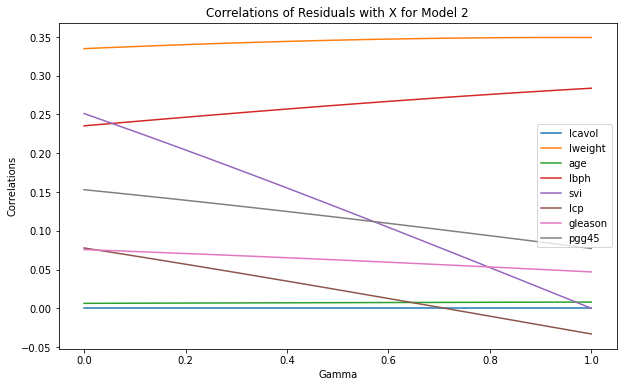

In [46]:
# code
gammas = np.linspace(0, 1, 100)
Y_hat = model_2.predict(X[:, selected_variables])

cor = []
for gamma in gammas:
    res = Y - gamma * Y_hat
    correlations = np.corrcoef(X.T, res.T)[-1, :8]  # Compute correlations
    cor.append(correlations)
cor = np.vstack(cor)

# plot
plt.figure(figsize=(10, 6))
for i in range(X.shape[1]):
    plt.plot(gammas, cor[:, i], label=df.columns[i])
plt.xlabel('Gamma')
plt.ylabel('Correlations')
plt.title('Correlations of Residuals with X for Model 2')
plt.legend()
plt.show()


### b9)

In [52]:
# I don't know, I give up

### b10)

### b11)